# Deep Learning -- Convolutional Neural Network (CNN) for Handwritten Digits Recognition

___
**Martin Guyard, https://github.com/9OP/DeepLearning**
___

The aim of this session is to practice with Convolutional Neural Networks. Each group should fill and run appropriate notebook cells. 

Follow instructions step by step until the end and submit your complete notebook as an archive (`tar -cf groupXnotebook.tar DL_lab2/`).

Do not forget to run all your cells before generating your final report and do not forget to include the names of all participants in the group. The lab session should be completed by the deadline on Moodle.

In the last lab session, you built a Multilayer Perceptron for recognizing hand-written digits from the MNIST dataset. The best achieved accuracy on testing data was >90%.  Can  you do better than these results using a deep CNN?
Now, let's build a more interesting model. In this notebook, you will build, train and optimize in TensorFlow one of the simplest Convolutional Neural Networks, **LeNet-5**, proposed by Yann LeCun, Leon Bottou, Yosuha Bengio and Patrick Haffner in 1998 (for more details, check the paper *"Gradient-Based Learning Applied to Document Recognition"*, Y.LeCun et al.).


Since, it's possible that this is our first time using Tensorflow, the next section will serve as introduction to this framework (*Note*: we will use TF 1.x).
**Please, even if there is no coding required -- do NOT skip it and READ carefully everything.**

In [6]:
# import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 
import numpy as np
# from tensorflow.examples.tutorials.mnist import input_data
import input_data

mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
X_train, y_train           = mnist.train.images, mnist.train.labels
X_validation, y_validation = mnist.validation.images, mnist.validation.labels
X_test, y_test             = mnist.test.images, mnist.test.labels

print("Image Shape: {}".format(X_train[0].shape))
print("Training Set:   {} samples".format(len(X_train)))
print("Validation Set: {} samples".format(len(X_validation)))
print("Test Set:       {} samples".format(len(X_test)))

epsilon = 1e-10 # this is a parameter you will use later

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Image Shape: (784,)
Training Set:   55000 samples
Validation Set: 5000 samples
Test Set:       10000 samples


# Introduction to Tensorflow 101
## TensorFlow Static Graph

The entire purpose of Tensorflow is to have a so-called computational graph that can be executed much more efficiently than if the same calculations were to be performed directly in Python. TensorFlow can be more efficient than NumPy because TensorFlow knows the entire computation graph that must be executed, while NumPy only knows the computation of a single mathematical operation at a time.

TensorFlow can also automatically calculate the gradients that are needed to optimize the variables of the graph so as to make the model perform better. This is because the graph is a combination of simple mathematical expressions so the gradient of the entire graph can be calculated using the chain-rule for derivatives.

TensorFlow can also take advantage of multi-core CPUs as well as GPUs - and Google has even built special hardware accelerators just for TensorFlow which are called TPUs (Tensor Processing Units) that are even faster than GPUs.

A TensorFlow graph consists of the following parts which will be detailed below:

- Placeholder variables used to feed input into the graph.
- Model variables that are going to be optimized so as to make the model perform better.
- The model which is essentially just a mathematical function that calculates some output given the input in the placeholder variables and the model variables.
- A cost measure that can be used to guide the optimization of the variables.
- An optimization method which updates the variables of the model.

In addition, the TensorFlow graph may also contain various debugging statements e.g. for logging data to be displayed using TensorBoard.

## Placeholder variables
Placeholder variables serve as the input to the graph that we may change each time we execute the graph. We call this feeding the placeholder variables and it is demonstrated further below.

First we define the placeholder variable for the input images. This allows us to change the images that are input to the TensorFlow graph. This is a so-called tensor, which just means that it is a multi-dimensional vector or matrix. The data-type is set to float32 and the shape is set to `[None, img_size_flat]`, where None means that the tensor may hold an arbitrary number of images with each image being a vector of length `img_size_flat` (in our case it's 784).

In [7]:
x = tf.placeholder(tf.float32, [None, 784], name='inputs')
print(x)

Tensor("inputs:0", shape=(?, 784), dtype=float32)


Next we have the placeholder variable for the true labels associated with the images that were input in the placeholder variable x. 
The shape of this placeholder variable is `[None, num_classes]` which means it may hold an arbitrary number of labels and each label is a vector of length `num_classes` which is 10 in this case.

In [8]:
y_true = tf.placeholder(tf.float32, [None, 10], name='labels')
print(y_true)

Tensor("labels:0", shape=(?, 10), dtype=float32)


Finally we have the tensor variable for the true class of each image in the placeholder variable `x`. These are integers and the dimensionality of this placeholder variable is set to `[None]` which means the placeholder variable is a one-dimensional vector of arbitrary length.

In [10]:
y_true_cls = tf.argmax(y_true, 1) 

## Variables to be optimized

Apart from the placeholder variables that were defined above and which serve as feeding input data into the model, there are also some model variables that must be changed by TensorFlow so as to make the model perform better on the training data.

The first variable that must be optimized is called `weights` and is defined here as a TensorFlow variable that must be initialized with zeros and whose shape is `[img_size_flat, num_classes]`, so it is a 2-dimensional tensor (or matrix) with `img_size_flat` rows and `num_classes` columns.

In [11]:
weights = tf.Variable(tf.zeros([784, 10]), name='weights')
print(weights)

<tf.Variable 'weights:0' shape=(784, 10) dtype=float32_ref>


The second variable that must be optimized is called `biases` and is defined as a 1-dimensional tensor (or vector) of length `num_classes`.

In [12]:
biases = tf.Variable(tf.zeros([10]), name='bias')
print(biases)

<tf.Variable 'bias:0' shape=(10,) dtype=float32_ref>


## Model

This simple mathematical model multiplies the images in the placeholder variable `x` with the `weights` and then adds the `biases`.

The result is a matrix of shape `[num_images, num_classes]` because `x` has shape `[num_images, img_size_flat]` and `weights` has shape `[img_size_flat, num_classes]`, so the multiplication of those two matrices is a matrix with shape `[num_images, num_classes]` and then the `biases` vector is added to each row of that matrix.

Note that the name `logits` is typical TensorFlow terminology, but other people may call the variable something else.

Now `logits` is a matrix with `num_images` rows and `num_classes` columns, where the element of the $i$'th row and $j$'th column is an estimate of how likely the $i$'th input image is to be of the $j$'th class.

However, these estimates are a bit rough and difficult to interpret because the numbers may be very small or large, so we want to normalize them so that each row of the `logits` matrix sums to one, and each element is limited between zero and one. This is calculated using the so-called softmax function and the result is stored in `y_pred`.

The predicted class can be calculated from the `y_pred` matrix by taking the index of the largest element in each row.

In [13]:
with tf.name_scope('model'):
    logits = tf.matmul(x, weights) + biases
    y_pred = tf.nn.softmax(logits)
    y_pred_cls = tf.argmax(y_pred, axis=1)

## Cost-function to be optimized

To make the model better at classifying the input images, we must somehow change the variables for `weights` and `biases`. To do this we first need to know how well the model currently performs by comparing the predicted output of the model `y_pred` to the desired output `y_true`.

The cross-entropy is a performance measure used in classification. The cross-entropy is a continuous function that is always positive and if the predicted output of the model exactly matches the desired output then the cross-entropy equals zero. The goal of optimization is therefore to minimize the cross-entropy so it gets as close to zero as possible by changing the `weights` and `biases` of the model.

TensorFlow has a built-in function for calculating the cross-entropy. Note that it uses the values of the `logits` because it also calculates the softmax internally.

After that, we have the cross-entropy for each of the image classifications so we have a measure of how well the model performs on each image individually. But in order to use the cross-entropy to guide the optimization of the model's variables we need a single scalar value, so we simply take the average of the cross-entropy for all the image classifications.

In [14]:
with tf.name_scope('loss'):
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits,
                                                               labels=y_true)
    loss = tf.reduce_mean(cross_entropy)

## Optimization
Now that we have a cost measure that must be minimized, we can then create an optimizer. In this case it is the basic form of Gradient Descent where the step-size is set to 0.01.

Note that optimization is not performed at this point. In fact, nothing is calculated at all, we just add the optimizer-object to the TensorFlow graph for later execution.

In [15]:
learning_rate = 0.01
with tf.name_scope('optim'):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    opt_step = optimizer.minimize(loss)

## Performance 

We need a few more performance measures to display the progress to the user.

This is a vector of booleans whether the predicted class equals the true class of each image.

This calculates the classification accuracy by first type-casting the vector of booleans to floats, so that False becomes 0 and True becomes 1, and then calculating the average of these numbers.

In [16]:
with tf.name_scope('accuracy'):
    correct_prediction = tf.equal(y_pred_cls, y_true_cls)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


## TensorFlow Session

Once the TensorFlow graph has been created, we have to create a TensorFlow session which is used to execute the graph.

In [17]:
session = tf.Session()

### Initialize variables
The variables for `weights` and `biases` must be initialized before we start optimizing them.

In [18]:
init_op = tf.global_variables_initializer()
session.run(init_op)

### Setup the TensorBoard

Tensorboard is shipped with TensorFlow and it's a tool that allows to plot metrics, debug the graph, and much more.

In [19]:
def next_path(path_pattern):
    import os
    i = 1
    while os.path.exists(path_pattern % i):
        i = i * 2
    a, b = (i / 2, i)
    while a + 1 < b:
        c = (a + b) / 2 
        a, b = (c, b) if os.path.exists(path_pattern % c) else (a, c)
    directory = path_pattern % b
    return directory


writer = tf.summary.FileWriter(next_path('logs/run_%02d'))
tf.summary.scalar("Loss", loss)
tf.summary.scalar("Accuracy", accuracy)
merged_summary_op = tf.summary.merge_all()


## Time to learn

Now that everything is defined, we can move to running the optimization.
There are 55.000 images in the training-set. It takes a long time to calculate the gradient of the model using all these images. We therefore use Stochastic Gradient Descent which only uses a small batch of images in each iteration of the optimizer.

In [21]:
batch_size = 100

Function for performing a number of optimization iterations so as to gradually improve the `weights` and `biases` of the model. In each iteration, a new batch of data is selected from the training-set and then TensorFlow executes the optimizer using those training samples. 

Let's define a couple of functions that will be usefull later.

In [20]:
def optimize(epochs):
    # Go through the traning dataset `epochs` times
    for e in range(epochs):
        
        num_of_batches = int(mnist.train.num_examples/batch_size)
        
        # We save also the loss across all the batches of data for 
        # presentation purpose
        avg_loss = 0.
        
        # Loop over all batches
        for i in range(num_of_batches):
            # Get a batch of training examples (shuffle every epoch).
            # x_batch now holds a batch of images and
            # y_true_batch are the true labels for those images.
            x_batch, y_true_batch = mnist.train.next_batch(batch_size, shuffle=(i==0))
            
            # Put the batch into a dict with the proper names
            # for placeholder variables in the TensorFlow graph.
            # Note that the placeholder for y_true_cls is not set
            # because it is not used during training.
            feed_dict_train = {x: x_batch,
                               y_true: y_true_batch}
            
            # Run the optimizer using this batch of training data.
            # TensorFlow assigns the variables in feed_dict_train
            # to the placeholder variables and then runs the optimizer.
            session.run(opt_step, feed_dict=feed_dict_train)
            
            # Similarly, get the loss and accuracy metrics on the batch of data
            batch_loss, summary = session.run([loss, merged_summary_op], feed_dict=feed_dict_train)
            
            # Write logs at every iteration
            writer.add_summary(summary, e * num_of_batches + i)
            
            # Compute average loss
            avg_loss += batch_loss / num_of_batches
            
        print("Epoch: ", '%02d' % (e + 1), "  =====> Loss =", "{:.6f}".format(avg_loss))

def print_accuracy():
    feed_dict_test = {x: mnist.test.images,
                  y_true: mnist.test.labels}
    
    # Use TensorFlow to compute the accuracy.
    # We are also going to save some metric like memory usage and computation time
    run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
    run_metadata = tf.RunMetadata()
    acc = session.run(accuracy, feed_dict=feed_dict_test, options=run_options, run_metadata=run_metadata)
    try:
        writer.add_run_metadata(run_metadata, 'inference')
    except ValueError:
        pass
    writer.flush()
    # Print the accuracy.
    print("Accuracy on test-set: {0:.1%}".format(acc))

Let's add the graph to TensorBoard for easy debugging

In [22]:
writer.add_graph(tf.get_default_graph())

### Performance before any optimization

The accuracy on the test-set is 9.8%. This is because the model has only been initialized and not optimized at all, so it always predicts that the image shows a zero digit and it turns out that 9.8% of the images in the test-set happens to be zero digits.

In [23]:
print_accuracy()

Accuracy on test-set: 9.8%


Now we can train the model for 50 epochs and print the accuracy.

In [24]:
optimize(50)
print_accuracy()

Epoch:  01   =====> Loss = 1.177134
Epoch:  02   =====> Loss = 0.662769
Epoch:  03   =====> Loss = 0.550719
Epoch:  04   =====> Loss = 0.496837
Epoch:  05   =====> Loss = 0.463803
Epoch:  06   =====> Loss = 0.440929
Epoch:  07   =====> Loss = 0.423961
Epoch:  08   =====> Loss = 0.410622
Epoch:  09   =====> Loss = 0.399933
Epoch:  10   =====> Loss = 0.390959
Epoch:  11   =====> Loss = 0.383317
Epoch:  12   =====> Loss = 0.376821
Epoch:  13   =====> Loss = 0.371031
Epoch:  14   =====> Loss = 0.365955
Epoch:  15   =====> Loss = 0.361362
Epoch:  16   =====> Loss = 0.357268
Epoch:  17   =====> Loss = 0.353512
Epoch:  18   =====> Loss = 0.350185
Epoch:  19   =====> Loss = 0.347017
Epoch:  20   =====> Loss = 0.344147
Epoch:  21   =====> Loss = 0.341466
Epoch:  22   =====> Loss = 0.338963
Epoch:  23   =====> Loss = 0.336681
Epoch:  24   =====> Loss = 0.334475
Epoch:  25   =====> Loss = 0.332421
Epoch:  26   =====> Loss = 0.330580
Epoch:  27   =====> Loss = 0.328745
Epoch:  28   =====> Loss = 0

Using Tensorboard, we can now visualize the created graph, giving you an overview of your architecture and how all of the major components are connected. You can also see and analyse the learning curves. 

To launch TensorBoard: 
- Open a Terminal and run the command line `tensorboard --logdir logs`
- Click on "Tensorboard web interface" in Zoe (available only within EURECOM network) 

Try to play with it: check the behaviour of the training procedure, check the graph and try to match the nodes with their definition in the code, check the profiling that we did for the inference (how much memory it requires, how long it takes, ...).

# LeNet5

You are now familar with **TensorFlow** and **TensorBoard**. In this section, you are to build, train and test the baseline [LeNet-5](http://yann.lecun.com/exdb/lenet/)  model for the MNIST digits recognition problem.  

Then, you will make some optimizations to get more than 99% of accuracy.

For more informations, have a look at this list of results: http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html


<img width="800" height="600" align="center" src=" 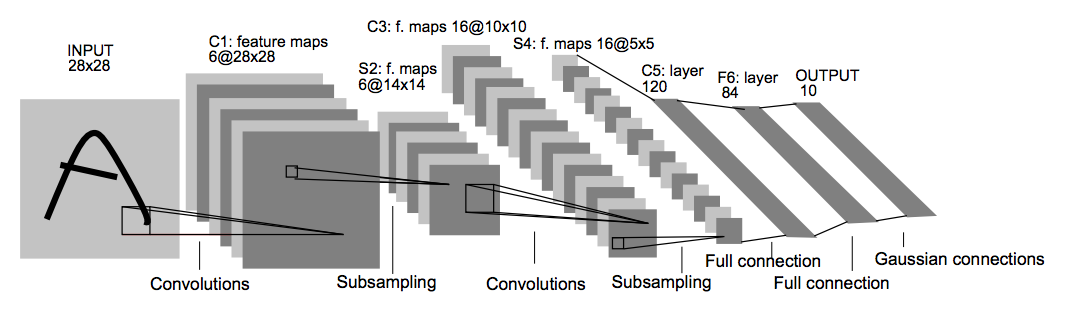">





The LeNet architecture takes a 28x28xC image as input, where C is the number of color channels. Since MNIST images are grayscale, C is 1 in this case.

--------------------------
**Layer 1 - Convolution (5x5):** The output shape should be 28x28x6. **Activation:** ReLU. **MaxPooling:** The output shape should be 14x14x6.

**Layer 2 - Convolution (5x5):** The output shape should be 10x10x16. **Activation:** ReLU. **MaxPooling:** The output shape should be 5x5x16.

**Flatten:** Flatten the output shape of the final pooling layer such that it's 1D instead of 3D.  You may need to use tf.reshape.

**Layer 3 - Fully Connected:** This should have 120 outputs. **Activation:** ReLU.

**Layer 4 - Fully Connected:** This should have 84 outputs. **Activation:** ReLU.

**Layer 5 - Fully Connected:** This should have 10 outputs. **Activation:** softmax.


<b> Question </b>  Implement the Neural Network architecture described above.
For that, your will use classes and functions from  https://www.tensorflow.org/api_docs/python/tf/nn. 

We give you some helper functions for weigths and bias initilization. Also you can refer to section 1. 


In [29]:
# Functions for weigths and bias initilization 
def weight_variable(shape, name):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial, name=name)

def bias_variable(shape, name):
    initial = tf.constant(0., shape=shape)
    return tf.Variable(initial, name=name)

In [32]:
def build_lenet5(x):
    with tf.name_scope("reshape"):
        image = tf.reshape(x, [-1, 28, 28, 1]) # [None, 28, 28, 1]
    
    with tf.name_scope("lenet5"):
        with tf.name_scope("layer1"):
            ## INIT
            # Weight size is: [ filter_size , number of filters   ]
            # filter size: 5x5x1, number of filters: 6
            conv1_w = weight_variable(shape=[5, 5, 1, 6], name="conv1_w")
            # There are as many bias as there are filters
            conv1_b = bias_variable(shape=[6], name="conv1_b")
            
            ## CONVOLUTION
            # Strides: NHWC,
            # N: number of images (batch size), it will be 1 for simplicity.
            # H: height of the image
            # W: Width of the image
            # C: number of channels (here 1  because grayscale)
            # Same padding: size of the output is the same as the input: 28x28 
            conv1 = tf.nn.conv2d(image, conv1_w, strides=[1, 1, 1, 1], padding="SAME") + conv1_b
            
            ## ACTIVATION
            # ReLu activation
            conv1 = tf.nn.relu(conv1)
            
            ## MAXPOOLING
            # Stride: ., 2, 2, 1: from 28x28x6 to 14x14x6
            pool_1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")

            
        with tf.name_scope("layer2"):
            ## INIT
            # filter size: 5x5x6, number of filters: 16
            conv2_w = weight_variable(shape=[5, 5, 6, 16], name="conv2_w")
            conv2_b = bias_variable(shape=[16], name="conv2_b")
            
            ## CONVOLUTION
            # Padding is "VALID" because from 14x14 to 10x10 with 5x5 filter
            conv2 = tf.nn.conv2d(pool_1, conv2_w, strides=[1, 1, 1, 1], padding="VALID") + conv2_b
            
            ## ACTIVATION
            conv2 = tf.nn.relu(conv2)
            
            ## MAXPOOLING
            pool_2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID" )
        
        
        with tf.name_scope("flatten"):
            # From 3D to 1D
            # From 5x5x16 to 400
            flat = tf.reshape(pool_2, [-1, 400], name="flatten")
            
                                     
        with tf.name_scope("layer3"):
            # From 400 to 120
            flat1_w = weight_variable(shape=[400, 120], name="weights_fully_1")
            flat1_b = bias_variable(shape=[120], name="bias_fully_1")
            
            # Fully connected layer
            flat1 = tf.matmul(flat, flat1_w) + flat1_b
            
            # ReLu
            flat1 = tf.nn.relu(flat1)
            
            
        with tf.name_scope("layer4"):
            # From 120 to 84
            flat2_w = weight_variable(shape=[120, 84], name="weights_fully_2")
            flat2_b = bias_variable(shape=[84], name="bias_fully_2" )
            
            # Fully connected layer
            flat2 = tf.matmul(flat1, flat2_w) + flat2_b
            
            # ReLu
            flat2 = tf.nn.relu(flat2)

            
        with tf.name_scope("layer5"):
            # From 84 to 10
            flat3_w = weight_variable(shape=[84,10], name="weights_fully_output")
            flat3_b = bias_variable(shape=[10], name="bias_fully_output" )
            
            # Fully connected layer
            logits = tf.matmul(flat2, flat3_w) + flat3_b
            # Softmax activation is defined outside because some function (cross entropy of acc)
            # already compute softmax.
        
    return logits

<b> Question  </b>  Calculate the number of parameters of this model 

- Layer 1 : (5x5x1 + 1) x 6 = 156
    - filtersize: 5x5x1
    - biase: + 1
    - number of conv filter: 6
    
    
- Layer 2 : (5x5x1 + 1) x 16 x 6 = 2496
    - filtersize: 5x5x1
    - biase: +1
    - number of conv filter: 16
    - number of input: 6 filters from layer 1 (16 filters applied to each of the 6 filters of layer1)
    
    
- Layer 3 : 400 x 120 + 120 = 48120
    - 400 input units
    - 120 output units
    - 120 biases: 1 per unit
    
    
- Layer 4 : 120 x 84 + 84 = 10164
    - 120 input units
    - 84 output units
    - 84 biases: 1 per unit
    
    
- Layer 5 : 84 x 10 + 10 = 850
    - 84 input units
    - 10 output units
    - 10 biases: 1 per unit
    
    
**Number of parameters: 156+2496+48120+10164+850 = 61786**

On the internet I found around 60k parameters for LeNet5, seems consistant with my calculation.

<b> Question </b>  Define your model, its accuracy and the loss function according to the following parameters (you can look at Section 1 to see what is expected):

     Learning rate: 0.001
     Loss Fucntion: Cross-entropy
     Optimizer: tf.train.GradientDescentOptimizer
     Number of epochs: 40
     Batch size: 128

In [33]:
tf.reset_default_graph() # reset the default graph before defining a new model

# Parameters
learning_rate = 0.001
batch_size = 128

# Model, loss function and accuracy
x = tf.placeholder(tf.float32, [None, 784], name='inputs')
y_true = tf.placeholder(tf.float32, [None, 10], name='labels')
y_true_cls = tf.argmax(y_true, 1) 

with tf.name_scope('model'):
    logits = build_lenet5(x)
    y_pred = tf.nn.softmax(logits) # Layer 5 activation function is defined here
    y_pred_cls = tf.argmax(y_pred, axis=1)

with tf.name_scope('loss'):
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=y_true)
    loss = tf.reduce_mean(cross_entropy)
    
with tf.name_scope('optim'):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate) # Simple SGD optimizer
    opt_step = optimizer.minimize(loss)
    
with tf.name_scope('accuracy'):
    correct_prediction = tf.equal(y_pred_cls, y_true_cls)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

session =  tf.Session()
init_op = tf.global_variables_initializer()
session.run(init_op)


writer = tf.summary.FileWriter(next_path('logs/lenet5/run_%02d'))
tf.summary.scalar("Loss", loss)
tf.summary.scalar("Accuracy", accuracy)
merged_summary_op = tf.summary.merge_all()

writer.add_graph(tf.get_default_graph())

**Question:**
Implement training pipeline and run the training data through it to train the model.

- Before each epoch, shuffle the training set. 
- Print the loss per mini batch and the training/validation accuracy per epoch. (Display results every 100 epochs)
- Save the model after training
- Print after training the final testing accuracy 



In [34]:
def optimize(epochs):
    # Go through the traning dataset `epochs` times
    for e in range(epochs):
        
        num_of_batches = int(mnist.train.num_examples/batch_size)
        
        # We save also the loss across all the batches of data for 
        # presentation purpose
        avg_loss = 0.
        
        # Loop over all batches
        for i in range(num_of_batches):
            # Get a batch of training examples (shuffle every epoch).
            # x_batch now holds a batch of images and
            # y_true_batch are the true labels for those images.
            x_batch, y_true_batch = mnist.train.next_batch(batch_size, shuffle=(i==0))
            
            # Put the batch into a dict with the proper names
            # for placeholder variables in the TensorFlow graph.
            # Note that the placeholder for y_true_cls is not set
            # because it is not used during training.
            feed_dict_train = {x: x_batch,
                               y_true: y_true_batch}
            
            # Run the optimizer using this batch of training data.
            # TensorFlow assigns the variables in feed_dict_train
            # to the placeholder variables and then runs the optimizer.
            session.run(opt_step, feed_dict=feed_dict_train)
            
            # Similarly, get the loss and accuracy metrics on the batch of data
            batch_loss, summary = session.run([loss, merged_summary_op], feed_dict=feed_dict_train)
            
            # Write logs at every iteration
            writer.add_summary(summary, e * num_of_batches + i)
            
            # Compute average loss
            avg_loss += batch_loss / num_of_batches
            
        print("Epoch: ", '%02d' % (e + 1), "  =====> Loss =", "{:.6f}".format(avg_loss))

def print_accuracy():
    feed_dict_test = {x: mnist.test.images,
                  y_true: mnist.test.labels}
    
    # Use TensorFlow to compute the accuracy.
    # We are also going to save some metric like memory usage and computation time
    run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
    run_metadata = tf.RunMetadata()
    acc = session.run(accuracy, feed_dict=feed_dict_test, options=run_options, run_metadata=run_metadata)
    try:
        writer.add_run_metadata(run_metadata, 'inference')
    except ValueError:
        pass
    writer.flush()
    # Print the accuracy.
    print("Accuracy on test-set: {0:.1%}".format(acc))

In [35]:
optimize(40)

Epoch:  01   =====> Loss = 2.295382
Epoch:  02   =====> Loss = 2.275604
Epoch:  03   =====> Loss = 2.249139
Epoch:  04   =====> Loss = 2.199265
Epoch:  05   =====> Loss = 2.085629
Epoch:  06   =====> Loss = 1.793648
Epoch:  07   =====> Loss = 1.221362
Epoch:  08   =====> Loss = 0.753995
Epoch:  09   =====> Loss = 0.545681
Epoch:  10   =====> Loss = 0.447751
Epoch:  11   =====> Loss = 0.392135
Epoch:  12   =====> Loss = 0.356013
Epoch:  13   =====> Loss = 0.329551
Epoch:  14   =====> Loss = 0.309669
Epoch:  15   =====> Loss = 0.293401
Epoch:  16   =====> Loss = 0.279250
Epoch:  17   =====> Loss = 0.267182
Epoch:  18   =====> Loss = 0.256065
Epoch:  19   =====> Loss = 0.246462
Epoch:  20   =====> Loss = 0.237657
Epoch:  21   =====> Loss = 0.229426
Epoch:  22   =====> Loss = 0.221930
Epoch:  23   =====> Loss = 0.215055
Epoch:  24   =====> Loss = 0.208639
Epoch:  25   =====> Loss = 0.202419
Epoch:  26   =====> Loss = 0.196787
Epoch:  27   =====> Loss = 0.191868
Epoch:  28   =====> Loss = 0

In [36]:
print_accuracy()

Accuracy on test-set: 95.7%


<b> Question </b> : Use TensorBoard to visualise and save loss and accuracy curves. 
You will save figures in the folder **"lab_2/MNIST_figures"** and display them in your notebook.

**LeNet5 SGD, batch 128, lr .001**

- Accuracy:
<img src=" 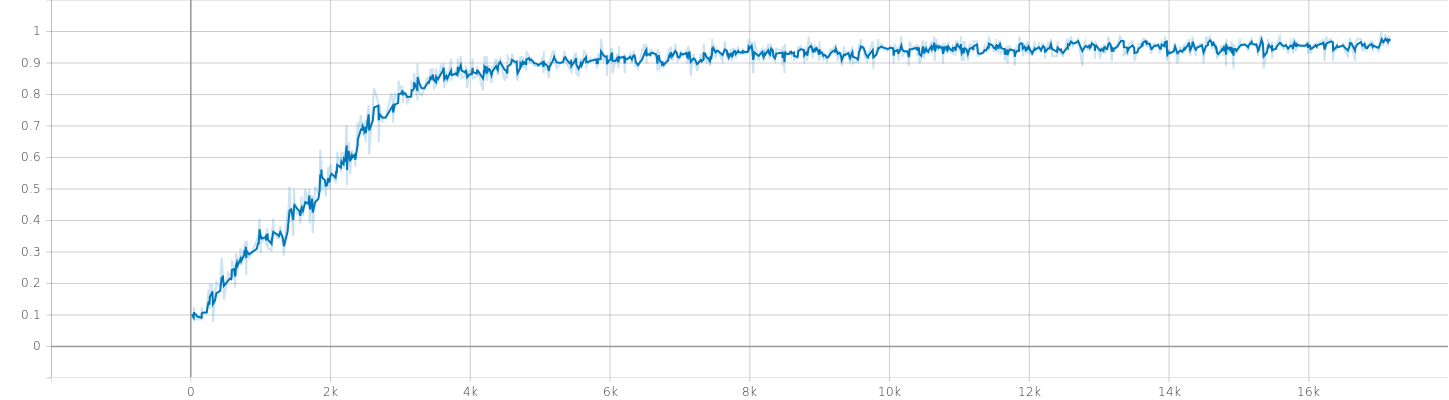">

- Loss:
<img src=" 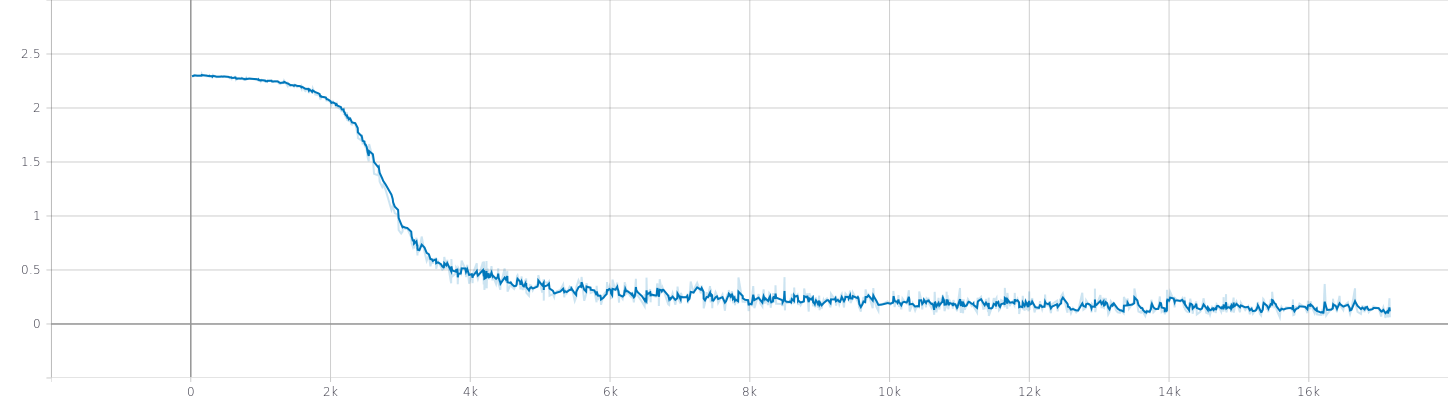">

## Improve the LeNET 5 Optimization


<b> Question </b>

- Retrain your network with AdamOptimizer and then fill the table above:


| Optimizer            |  Gradient Descent  |    AdamOptimizer    |
|----------------------|--------------------|---------------------|
| Testing Accuracy     |         95.7%        |        98.8%          |       
| Training Time        |         13min 1s        |        12min 47s          |  

- Which optimizer gives the best accuracy on test data?

**Your answer:** AdamOptimizer obviously


In [37]:
tf.reset_default_graph() # reset the default graph before defining a new model

# Parameters
learning_rate = 0.001
batch_size = 128

# Model, loss function and accuracy
x = tf.placeholder(tf.float32, [None, 784], name='inputs')
y_true = tf.placeholder(tf.float32, [None, 10], name='labels')
y_true_cls = tf.argmax(y_true, 1) 

with tf.name_scope('model'):
    logits = build_lenet5(x)
    y_pred = tf.nn.softmax(logits) # Layer 5 activation function is defined here
    y_pred_cls = tf.argmax(y_pred, axis=1)

with tf.name_scope('loss'):
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=y_true)
    loss = tf.reduce_mean(cross_entropy)
    
with tf.name_scope('optim'):
    optimizer = tf.train.AdamOptimizer(learning_rate) #  Adam optimizer
    opt_step = optimizer.minimize(loss)
    
with tf.name_scope('accuracy'):
    correct_prediction = tf.equal(y_pred_cls, y_true_cls)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

session =  tf.Session()
init_op = tf.global_variables_initializer()
session.run(init_op)


writer = tf.summary.FileWriter(next_path('logs/lenet5/run_%02d'))
tf.summary.scalar("Loss", loss)
tf.summary.scalar("Accuracy", accuracy)
merged_summary_op = tf.summary.merge_all()

writer.add_graph(tf.get_default_graph())

In [38]:
optimize(40)
print_accuracy()

Epoch:  01   =====> Loss = 0.334405
Epoch:  02   =====> Loss = 0.084121
Epoch:  03   =====> Loss = 0.055955
Epoch:  04   =====> Loss = 0.041970
Epoch:  05   =====> Loss = 0.034244
Epoch:  06   =====> Loss = 0.028109
Epoch:  07   =====> Loss = 0.022586
Epoch:  08   =====> Loss = 0.017606
Epoch:  09   =====> Loss = 0.013957
Epoch:  10   =====> Loss = 0.011657
Epoch:  11   =====> Loss = 0.009708
Epoch:  12   =====> Loss = 0.008814
Epoch:  13   =====> Loss = 0.006614
Epoch:  14   =====> Loss = 0.005484
Epoch:  15   =====> Loss = 0.004506
Epoch:  16   =====> Loss = 0.005227
Epoch:  17   =====> Loss = 0.005029
Epoch:  18   =====> Loss = 0.003745
Epoch:  19   =====> Loss = 0.003311
Epoch:  20   =====> Loss = 0.002539
Epoch:  21   =====> Loss = 0.002365
Epoch:  22   =====> Loss = 0.002831
Epoch:  23   =====> Loss = 0.002252
Epoch:  24   =====> Loss = 0.001852
Epoch:  25   =====> Loss = 0.002632
Epoch:  26   =====> Loss = 0.001745
Epoch:  27   =====> Loss = 0.001638
Epoch:  28   =====> Loss = 0

<b> Question </b> Try to add dropout (keep_prob = 0.75) before the first fully connected layer. You will use `tf.nn.dropout` for that purpose. What accuracy do you achieve on testing data?

**Accuracy achieved on testing data:** 97.5% (Better than SGD, worse than Adam without dropout)

In [39]:
def build_lenet5(x):
    with tf.name_scope("reshape"):
        image = tf.reshape(x, [-1, 28, 28, 1]) # [None, 28, 28, 1]
    
    with tf.name_scope("lenet5"):
        with tf.name_scope("layer1"):
            ## INIT
            # Weight size is: [ filter_size , number of filters   ]
            # filter size: 5x5x1, number of filters: 6
            conv1_w = weight_variable(shape=[5, 5, 1, 6], name="conv1_w")
            # There are as many bias as there are filters
            conv1_b = bias_variable(shape=[6], name="conv1_b")
            
            ## CONVOLUTION
            # Strides: NHWC,
            # N: number of images (batch size), it will be 1 for simplicity.
            # H: height of the image
            # W: Width of the image
            # C: number of channels (here 1  because grayscale)
            # Same padding: size of the output is the same as the input: 28x28 
            conv1 = tf.nn.conv2d(image, conv1_w, strides=[1, 1, 1, 1], padding="SAME") + conv1_b
            
            ## ACTIVATION
            # ReLu activation
            conv1 = tf.nn.relu(conv1)
            
            ## MAXPOOLING
            # Stride: ., 2, 2, 1: from 28x28x6 to 14x14x6
            pool_1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")

            
        with tf.name_scope("layer2"):
            ## INIT
            # filter size: 5x5x6, number of filters: 16
            conv2_w = weight_variable(shape=[5, 5, 6, 16], name="conv2_w")
            conv2_b = bias_variable(shape=[16], name="conv2_b")
            
            ## CONVOLUTION
            # Padding is "VALID" because from 14x14 to 10x10 with 5x5 filter
            conv2 = tf.nn.conv2d(pool_1, conv2_w, strides=[1, 1, 1, 1], padding="VALID") + conv2_b
            
            ## ACTIVATION
            conv2 = tf.nn.relu(conv2)
            
            ## MAXPOOLING
            pool_2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID" )
        
        
        with tf.name_scope("flatten"):
            # From 3D to 1D
            # From 5x5x16 to 400
            flat = tf.reshape(pool_2, [-1, 400], name="flatten")
            
                                     
        with tf.name_scope("layer3"):
            # From 400 to 120
            flat1_w = weight_variable(shape=[400, 120], name="weights_fully_1")
            flat1_b = bias_variable(shape=[120], name="bias_fully_1")
            
            # Add dropout (randomly shut down units, regularization method)
            flat = tf.nn.dropout(flat, rate=0.75)
            
            # Fully connected layer
            flat1 = tf.matmul(flat, flat1_w) + flat1_b
            
            # ReLu
            flat1 = tf.nn.relu(flat1)
            
            
        with tf.name_scope("layer4"):
            # From 120 to 84
            flat2_w = weight_variable(shape=[120, 84], name="weights_fully_2")
            flat2_b = bias_variable(shape=[84], name="bias_fully_2" )
            
            # Fully connected layer
            flat2 = tf.matmul(flat1, flat2_w) + flat2_b
            
            # ReLu
            flat2 = tf.nn.relu(flat2)

            
        with tf.name_scope("layer5"):
            # From 84 to 10
            flat3_w = weight_variable(shape=[84,10], name="weights_fully_output")
            flat3_b = bias_variable(shape=[10], name="bias_fully_output" )
            
            # Fully connected layer
            logits = tf.matmul(flat2, flat3_w) + flat3_b
            # Softmax activation is defined outside because some function (cross entropy of acc)
            # already compute softmax.
        
    return logits

In [40]:
tf.reset_default_graph() # reset the default graph before defining a new model

# Parameters
learning_rate = 0.001
batch_size = 128

# Model, loss function and accuracy
x = tf.placeholder(tf.float32, [None, 784], name='inputs')
y_true = tf.placeholder(tf.float32, [None, 10], name='labels')
y_true_cls = tf.argmax(y_true, 1) 

with tf.name_scope('model'):
    logits = build_lenet5(x)
    y_pred = tf.nn.softmax(logits) # Layer 5 activation function is defined here
    y_pred_cls = tf.argmax(y_pred, axis=1)

with tf.name_scope('loss'):
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=y_true)
    loss = tf.reduce_mean(cross_entropy)
    
with tf.name_scope('optim'):
    optimizer = tf.train.AdamOptimizer(learning_rate) #  Adam optimizer
    opt_step = optimizer.minimize(loss)
    
with tf.name_scope('accuracy'):
    correct_prediction = tf.equal(y_pred_cls, y_true_cls)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

session =  tf.Session()
init_op = tf.global_variables_initializer()
session.run(init_op)


writer = tf.summary.FileWriter(next_path('logs/lenet5/run_%02d'))
tf.summary.scalar("Loss", loss)
tf.summary.scalar("Accuracy", accuracy)
merged_summary_op = tf.summary.merge_all()

writer.add_graph(tf.get_default_graph())

In [41]:
optimize(40)
print_accuracy()

Epoch:  01   =====> Loss = 0.692655
Epoch:  02   =====> Loss = 0.266475
Epoch:  03   =====> Loss = 0.216110
Epoch:  04   =====> Loss = 0.187483
Epoch:  05   =====> Loss = 0.172462
Epoch:  06   =====> Loss = 0.155063
Epoch:  07   =====> Loss = 0.146381
Epoch:  08   =====> Loss = 0.141965
Epoch:  09   =====> Loss = 0.133456
Epoch:  10   =====> Loss = 0.127217
Epoch:  11   =====> Loss = 0.122845
Epoch:  12   =====> Loss = 0.117849
Epoch:  13   =====> Loss = 0.114164
Epoch:  14   =====> Loss = 0.114726
Epoch:  15   =====> Loss = 0.110333
Epoch:  16   =====> Loss = 0.106750
Epoch:  17   =====> Loss = 0.103674
Epoch:  18   =====> Loss = 0.103927
Epoch:  19   =====> Loss = 0.099789
Epoch:  20   =====> Loss = 0.094066
Epoch:  21   =====> Loss = 0.093958
Epoch:  22   =====> Loss = 0.095855
Epoch:  23   =====> Loss = 0.091105
Epoch:  24   =====> Loss = 0.092252
Epoch:  25   =====> Loss = 0.087002
Epoch:  26   =====> Loss = 0.086802
Epoch:  27   =====> Loss = 0.084462
Epoch:  28   =====> Loss = 0